# Trading Challenge

You are given a CSV file containing weekly returns (i.e. 𝑃𝑡𝑃𝑡−1−1 ) for a set of stocks. Create a basic program (in a language of your choice) to answer the following questions:
1. Which stock performed the best over the last 5 years?
2. Which stock performed the worst over the last 5 years?
3. What would $100 invested 5 years ago in each of the stocks in questions 1 and 2 be worth now?
4. Over the last 3 years, which 10 stocks were the most correlated with the stock with ID 210449?
5. And over the 3 years ending 1 March 2017?
6. Does one of the groups of 10 stocks from questions 4 & 5 seem more homogenous than the other? Explain how you reach your answer.
Please share the code (and background thinking) to answer questions 1-6.

In [9]:
import pandas as pd
from pandas import DataFrame
from datetime import datetime, date
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

In [10]:
dataframe = pd.read_csv('QuantDataExercise.csv')
print(dataframe.head())
# print(stock_ids)

   StockId        Date     Value
0    23262  2013-01-04  0.040734
1    44446  2013-01-04  0.020318
2    61943  2013-01-04  0.060932
3    75488  2013-01-04  0.043196
4    79454  2013-01-04  0.076799


## Aggregation Classes

In [11]:
class StockMetaData:
    def __init__(self, mean, std_dev, start_date, end_date, weeks = None):
        self.mean = mean
        self.std_dev = std_dev
        
        # record dates
        if isinstance(start_date, date):
            self.start_date = start_date
        else:
            self.start_date = datetime.strptime(start_date, '%Y-%m-%d')
        if isinstance(end_date, date):
            self.end_date = end_date
        else:
            self.end_date = datetime.strptime(end_date, '%Y-%m-%d')
        
        # calculate weeks recorded for
        if weeks is None:
            self.weeks = int(1+(self.end_date-self.start_date).days/7)
        else:
            self.weeks = weeks

# just a dictionary that you can access values via obj.key
class ReturnClass(dict):
    def __getattr__(self, name):
        return self[name]

# Base Class: Gets data into Correct Format

In [12]:
class StockData:
    def __init__(self, raw_stock_data, starting_price):
        self.starting_price = starting_price
        
        # dictionary of StockId:2134 keys and a pd.DataFrame with columns [Date, Return, Price] as the value
        self.stock_data = self.calculate_stock_data(raw_stock_data)
        
        # Dictonary of metadata: (mean, std_dev, start_date, end_date, weeks)
        self.meta_data = self.calculate_stock_meta_data()
        self.all_dates = pd.to_datetime(np.unique(raw_stock_data['Date'])) # list of datetime objs
        
    def calculate_stock_data(self, raw_stock_data):
        """
        Takes as input raw stock data for weekly returns in date order.
        returns:
            A dictionary where keys = 'StockId:id' 
                               values = pd.DataFrame with columns [Date, Return, Price]
                            
            for all stock ids given in raw stock data. The dates are datetime objects
        """
        stock_ids = np.unique(raw_stock_data['StockId'])   # get all of the ids
        stock_data = {}    # dictionary to store {stock_id: stock_data} where stock_data is a dataframe

        for id_num in stock_ids:
            stock_filter = (raw_stock_data['StockId'] == id_num) # only get data for the current stock
            
            
            stock_dates = pd.to_datetime(raw_stock_data[stock_filter]['Date']) # Series of datetimes
            returns = raw_stock_data[stock_filter]['Value'].values  # list of numpy floats
            
            # calculate prices p_t = (r_t + 1)*p_(t-1), where p_-1 = self.starting_price
            prices = []
            for date_idx, rtn in enumerate(returns):
                if date_idx == 0:
                    prices.append((returns[0]+1)*self.starting_price)
                    
                if date_idx != len(returns)-1:
                    prices.append((rtn + 1)*prices[date_idx])
            
            new_stock_data =  DataFrame({'Date': stock_dates,
                                         'Return': returns,
                                         'Price': prices
                                        })
            # add the data to the dict
            stock_data['StockId:'+str(id_num)] = new_stock_data        
        return stock_data
    
    def calculate_stock_meta_data(self):
        """
        Takes self.stock_data in dictionary form
        returns:
            A dictionary where:
            keys = 'StockId:id' 
            values = StockMetaData(mean, std_dev, start_date, end_date, number of weeks)
        """
        meta_data = {}
        for stock_id in self.stock_data:
            stock_dataframe = self.stock_data[stock_id]
            meta_data[stock_id] = StockMetaData(stock_dataframe['Return'].mean(), 
                                              stock_dataframe['Return'].std(),
                                              min(stock_dataframe['Date']),
                                              max(stock_dataframe['Date']),
                                              len(stock_dataframe['Date'])
                                             )
        return meta_data

## Child Class for Comparing Data for this Exercise

In [13]:
class CompareStocks(StockData):
    def __init__(self, raw_stock_data):
        
        self.starting_price = 100
        self.top_corrs = 10
        super().__init__(raw_stock_data, self.starting_price)
        
        # get a list of triples [(stock_id, mean, std), ...] sorted by their mean
        self.sorted_by_mean = [(stock_id, self.meta_data[stock_id].mean, self.meta_data[stock_id].std_dev) 
                         for stock_id in self.meta_data]
        self.sorted_by_mean.sort(key=lambda x:x[1])    
    
    def plot_mean_vs_std(self, top = 10, bottom = 10):
        """
        Plots a scatter of mean weekly returns vs standard deviation 
        Adds an interactive aspect to see the relationship between the two
        """
        # extract the highest and lowest means for annotating data points
        annotations = self.sorted_by_mean[:bottom]
        annotations.extend(self.sorted_by_mean[-top:])        
        
        @interact(m =(0, 40, 0.5), y_inter=(-0.1, 0.3, 0.01))
        def plot1(m=6, y_inter=-0.01):
            # fig is fine in this context
            fig = plt.figure(figsize=(12,10))
            ret = np.linspace(-0.03, 0.03, 20)

            for stock_id in self.meta_data:
                if self.meta_data[stock_id].weeks != 298:  # < 5 years of data
                    plt.scatter(self.meta_data[stock_id].mean, 
                                self.meta_data[stock_id].std_dev, 
                                marker='o',
                                color=['cornflowerblue']
                               )
                if self.meta_data[stock_id].weeks == 298:  # 5 years of data
                    plt.scatter(self.meta_data[stock_id].mean, 
                                self.meta_data[stock_id].std_dev, 
                                marker='x',
                                color=['darkorange']
                               )
            plt.xlabel("Mean Weekly Returns") 
            plt.ylabel("Weekly Return Standard Deviation")
            plt.legend(['Stocks with 5 years of Data', 'Stocks without 5 years of Data'])
            plt.plot(ret, ret*m+y_inter, 'r--')
            plt.ylim([0, 0.15])

            # Annotate the Stocks with the highest and lowest means
            for stock in annotations:
                label, x, y = stock[0], stock[1], stock[2]
                plt.annotate(
                    label,
                    xy=(x, y), xytext=(-5, 5),
                    textcoords='offset points', ha='left', va='bottom',)
            plt.show()
    
    def plot_stock_data(self, prices=False, stock_ids=None):
        """
        By default plot the stocks with the top 10 and bottom 10 means
        Otherwise plot the stocks sent in 'stocks'
        """
        # extract the id_number from means and 
        if stock_ids is None:
            stock_ids = self.sorted_by_mean[:10]
            stock_ids.extend(self.sorted_by_mean[-10:])
            stock_ids = [x[0] for x in stock_ids]    
        
        fig = plt.figure(figsize=(18,7))
        plt.legend(stock_ids)
        plt.xlabel("Date")
        
        for stock_id in stock_ids:
            if prices:
                plt.plot(self.stock_data[stock_id]['Date'], self.stock_data[stock_id]['Price'])
                plt.ylabel('Stock Price')
            else:
                plt.plot(self.stock_data[stock_id]['Date'], self.stock_data[stock_id]['Return'])
                plt.xlabel('Weekly Return')
        
        plt.legend(stock_ids)
        plt.show()
    
    def stock_significance(self, this_stock, greater_than=0, calc_mean_variance = False):
        """
        Computes significance statistics of a stock: p(return > greater_than).
        If is_mean_variance == True then calculate the probabiltiy of the mean of this_stock
        being greater_than a value.
        """
        
        mean = self.meta_data[this_stock].mean
        variance = self.meta_data[this_stock].std_dev ** 2
        if calc_mean_variance:
            # if working with p(mean > gt) then more data points will decrease the variance of the mean
            variance /= self.meta_data[this_stock].weeks             
        
        # generate points of the gaussian pdf describing this_stock
        std_dev = np.sqrt(variance)
        xs = np.linspace(mean-3*std_dev, mean+3*std_dev, 200)
        ys = np.exp(-0.5*(xs-mean)**2/variance)/np.sqrt(2*variance*np.pi)
        
        # then calculate the conditional cdf
        idx = (np.abs(xs-greater_than)).argmin()
        prob_return_greater_than = np.trapz(ys[idx:], xs[idx:])
        
        # aggregate things into a return class
        returns = ReturnClass({
            'prob_return_greater_than': prob_return_greater_than,
            'mean': mean,
            'std_dev': std_dev,
            'xs': xs,
            'ys': ys
        })
        
        return returns
    
    def compare_stocks(self, this_stock, that_stock, plot = False, calc_mean_variance=False):
        """
        Computes the difference of gaussians of the two stocks and therefore compares
        p(this_stock > that_stock)'s returns
        """
        
        this_sig = self.stock_significance(this_stock, calc_mean_variance)
        that_sig = self.stock_significance(that_stock, calc_mean_variance)
        
        # Calculate difference of gaussians stats (mode == mean for gaussians) 
        diff_mean = this_sig.mean - that_sig.mean
        diff_std = np.sqrt(this_sig.std_dev**2 + that_sig.std_dev**2)
        
        # Generate points of the difference of gaussians
        diff_xs = np.linspace(diff_mean-3*diff_std, diff_mean+3*diff_std, 200)
        diff_ys = ys = np.exp(-0.5*(diff_xs-diff_mean)**2/(diff_std**2))/np.sqrt(2*np.pi*diff_std**2)
        
        # Calculate the difference of gaussians
        idx = (np.abs(diff_xs - 0)).argmin()   # find the index where x=0 (or closest to)
        this_gt_that = np.trapz(diff_ys[idx:], diff_xs[idx:])
        
        if plot:
            # Plot the gaussians, mean lines and histograms if not comparing standard error distributions
            plt.plot(this_sig.xs, this_sig.ys); plt.plot(that_sig.xs, that_sig.ys); plt.plot(diff_xs, diff_ys)
            
            plt.gca().set_prop_cycle(None) # reset the colour cycles
            plt.plot([this_sig.mean, this_sig.mean], [0, max(this_sig.ys)], '--')
            plt.plot([that_sig.mean, that_sig.mean], [0, max(that_sig.ys)], '--')
            plt.plot([diff_mean, diff_mean], [0, max(diff_ys)], '--')

            if calc_mean_variance:
                plt.xlabel('Stock Mean')
            else:
                plt.gca().set_prop_cycle(None) # reset the colour cycles
                this_return = self.stock_data[this_stock]['Return']
                that_return = self.stock_data[that_stock]['Return']
                this_return.plot.hist(bins = 20, density = True, alpha = 0.3)
                that_return.plot.hist(bins = 20, density = True, alpha = 0.3)
                plt.xlabel('Weekly Returns')
            plt.ylabel('Probability')
            plt.legend([this_stock, that_stock, "The Normal Difference Distribution: "+this_stock+"-"+that_stock])
            plt.show()            

        returns = ReturnClass({
            'stocka_gt_stockb': this_gt_that,
            'stocka_gt_0': this_sig.prob_return_greater_than,
            'stockb_gt_0': that_sig.prob_return_greater_than
        })
        return returns
    
    def get_stock_correlations(self, base_stock, start_date, end_date=None, plot=False):
        """
        Takes a stock to compare all other stocks with and a time frame as arguments
        Returns:
            List of cross-correlations of base_stock with all other stocks
        """
        # Convert Dates Into the Correct Format
        if isinstance(start_date, date):
            start_date = start_date
        else:
            start_date = datetime.strptime(start_date, '%Y-%m-%d')        
        
        if isinstance(end_date, date):
            end_date = end_date
        elif end_date is None:
            end_date = max(self.all_dates)
        else:
            end_date = datetime.strptime(end_date, '%Y-%m-%d')
        # get the number of weeks between the start and end dates
        min_num_weeks = int(1+(end_date-start_date).days/7)
        
        # Extract the dates that we want
        stock_dates = self.stock_data[base_stock]['Date']
        if len(stock_dates) <= min_num_weeks:
            raise ValueError('The input stock does not have enough data for the start/end dates input')
        date_range_filter = (stock_dates >= start_date) & (stock_dates <= end_date)
        base_stock_data = self.stock_data[base_stock][date_range_filter]
        
        xcorr = []   # note, xcorr_price == xcorr_returns -> no need to compute both
        for stock_id in self.stock_data:
            stock_dates = self.stock_data[stock_id]['Date']
            
            # only compare the stock if it has dates within the date range 
            if min(stock_dates)<=start_date and max(stock_dates)>=end_date:
                date_range_filter = (stock_dates >= start_date) & (stock_dates <= end_date)
                compare_stock = self.stock_data[stock_id][date_range_filter]
                
                # for some reason the pandas base.corr(compare) doesn't work? (sans .values)
                correlation = np.corrcoef(base_stock_data['Return'].values, compare_stock['Return'].values)
                xcorr.append((stock_id, correlation[0][1])) # gives a symmetric 2x2 array - so take a non-diag element 
        
        xcorr.sort(key=lambda x: x[1], reverse=True)
        if plot:
            top_stocks = list(zip(*xcorr[1:self.top_corrs+1])) # get top ten stocks not including itself (xcorr=1)
            plt.barh(top_stocks[0], top_stocks[1])
            plt.title('Stocks with the highest correlation with '+base_stock+' \nbetween '+str(start_date)+' and '+str(end_date))
            plt.xlabel('Correlation Coefficient')
            plt.show()
            
        return xcorr
        

In [14]:
stock_compare = CompareStocks(dataframe)
print(stock_compare.stock_data['StockId:147'].head()) # show what the dataframe looks like

          Date    Return       Price
52  2013-01-04  0.049552  104.955202
183 2013-01-11  0.021211  110.155944
314 2013-01-18  0.013127  112.492505
445 2013-01-25 -0.040021  113.969167
576 2013-02-01  0.008288  109.407992


# Stock Performance

In [15]:
stock_compare.plot_mean_vs_std(top=10, bottom=10)

interactive(children=(FloatSlider(value=6.0, description='m', max=40.0, step=0.5), FloatSlider(value=-0.01, de…

Using a risk-adverse strategy, we can work out which returns are least likely to lose us money.

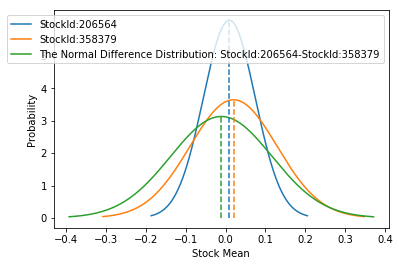

{'stocka_gt_stockb': 0.4686087917568375, 'stocka_gt_0': 0.0, 'stockb_gt_0': 0.0}


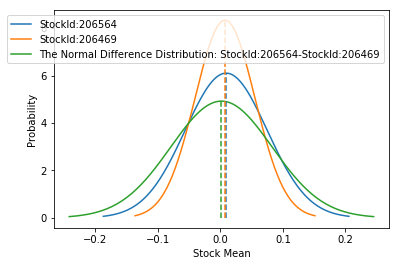

{'stocka_gt_stockb': 0.5046626167029454, 'stocka_gt_0': 0.0, 'stockb_gt_0': 0.0}


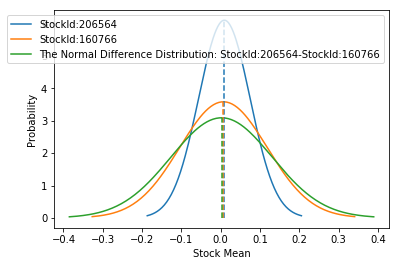

{'stocka_gt_stockb': 0.5046626167029453, 'stocka_gt_0': 0.0, 'stockb_gt_0': 0.0}


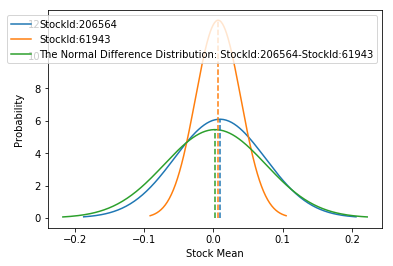

{'stocka_gt_stockb': 0.5166841961987018, 'stocka_gt_0': 0.0, 'stockb_gt_0': 0.0}


In [16]:
# sr.compare_stats('StockId:134657', 'StockId:206564', plot = True) #, stock_ids=['StockId:134657', 'StockId:206564'])
# 'StockId:358379'
print(stock_compare.compare_stocks('StockId:206564', 'StockId:358379', plot = True, calc_mean_variance = True))
print(stock_compare.compare_stocks('StockId:206564', 'StockId:206469', plot = True, calc_mean_variance = True))
print(stock_compare.compare_stocks('StockId:206564', 'StockId:160766', plot = True, calc_mean_variance = True))
print(stock_compare.compare_stocks('StockId:206564', 'StockId:61943', plot = True, calc_mean_variance = True))

Two ways of measuring stock performance over the last 5 years are:

    1) Comparing mean weekly returns, i.e.~which made the highest returns on average?
    2) Comparing the volatility of returns, i.e.~which were the least likely to lose money?
    
In terms of mean weekly returns: stock 358379 with $\mu = 0.020082$
had the highest, and stock 358376 had the lowest with
$\mu = -0.024626$. However, these returns did not run for the full 5
years.

Using only returns which have data for the full 5 years, we can compare
the weekly returns to find the top 5 (x1000):

    1) Stock: 206564     9.386
    2) Stock: 206469     7.560
    3) Stock: 160766     7.100
    4) Stock: 61943      6.918
    5) Stock: 199782     5.161

Similarly for the returns with the lowest mean weekly returns (x1000):

    1) Stock: 100376    -12.245
    2) Stock: 122637    -6.091
    3) Stock: 26237     -4.774
    4) Stock: 153695    -4.540
    5) Stock: 41813     -3.964

Stock 100376 was clearly the worst, with a very high standard deviation
and an average weekly return more than twice as low as the next stock.

The best performing returns are closer together, and the volatility of
the returns should be taken into account more. We can do this by
comparing $p(Stock A > Stock B)$ to see if there is a significant
difference between two returns with seemingly large differences in mean
weekly returns. For example a stock with an extremely high variance may
only have a slightly higher probability of a weekly return being higher
even if the mean weekly returns are much higher. Figure \ref{fig:1} shows mean weekly returns vs standard deviation. This suggests that stocks 160766 is likely to be worst than the others in the top 5 and 61943 is likely to be better than expected, even though it has a lower mean weekly return. 

Additionally, we could take a risk-adverse strategy and find which
returns are the least likely to have a negative weekly return,
$p(Stock > 0)$.

%%latex
\begin{table}
\centering
\begin{tabular}{|c|l|ccccc}
\hline
\multicolumn{2}{|c|}{\multirow{2}{*}{\textbf{p(A\textgreater{}B)}}} & \multicolumn{5}{c|}{\textbf{A}}                                                                                                                           \\ \cline{3-7} 
\multicolumn{2}{|c|}{}                                              & \multicolumn{1}{l|}{0} & \multicolumn{1}{l|}{st:206564} & \multicolumn{1}{l|}{st:206469} & \multicolumn{1}{l|}{st:160766} & \multicolumn{1}{l|}{st:61943} \\ \hline
\multirow{5}{*}{\textbf{B}}               & 0                       & -                      & 0.552                          & 0.564                          & 0.564                          & 0.588                         \\ \cline{2-2}
                                          & st:206564               & -                      & -                              & -                              & -                              & -                             \\ \cline{2-2}
                                          & st:206469               & -                      & 0.505                          & -                              & -                              & -                             \\ \cline{2-2}
                                          & st:160766               & -                      & 0.505                          & 0.505                          & -                              & -                             \\ \cline{2-2}
                                          & st:61943                & -                      & 0.517                          & 0.508                          & 0.505                          & -                             \\ \cline{1-2}
\end{tabular}
\caption{A Table Showing comparisons between different stock returns.}
\end{table}

The results in the table above show that stock 206564 is the most likely to have a greater weekly return than the others, however of the top four stocks it is the least likely to have a positive return. Stock 61943 is the most likely to have a positive return, and that stock 206564 only has a 52\%
probability of having a greater weekly return than stock 61943. However,
if we compare the standard errors of the sample means we see that stock
206564 has a 72\% chance of having a higher mean than stock 61943, which
is significantly higher than stock 206469 and stock 160766, which were
58\% and 51\% more likely to have a higher sample mean.

# Investment Values $(P_{t=0} = 100)$

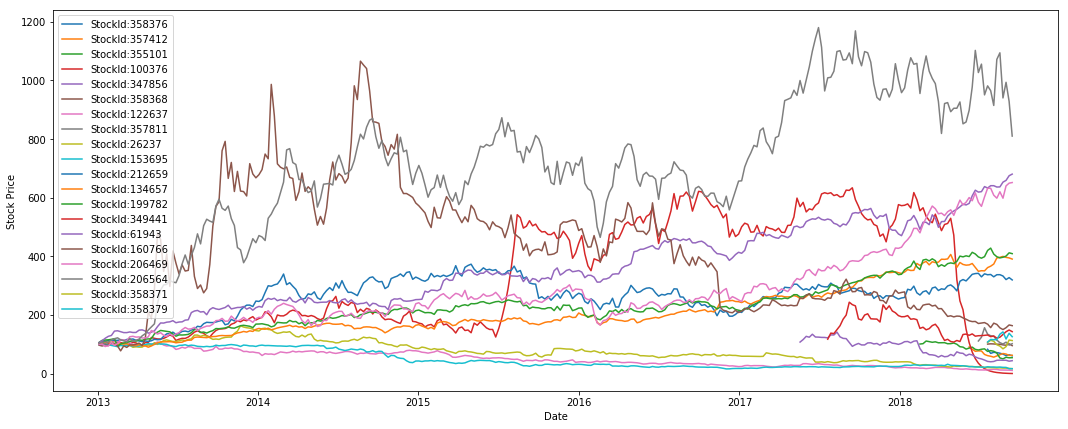

In [17]:
stock_compare.plot_stock_data(prices=True)

In conclusion, stock 206564 was the best performing stock over the last
5 years. Figure The figure shows the value of a portfolio if each of the top 5 best and worst stocks had £100 invested in them at the start of the 5 years. As expected, this shows that Stock 206564 and Stock 100376 were the best performing and worst performing, ending with £877 and £0.46 respectively.

# Stock Correlations

The correlation coefficients of the 10 most correlated stocks for two different 3-year time periods are shown in the figures below

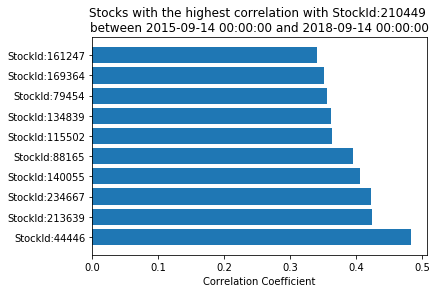

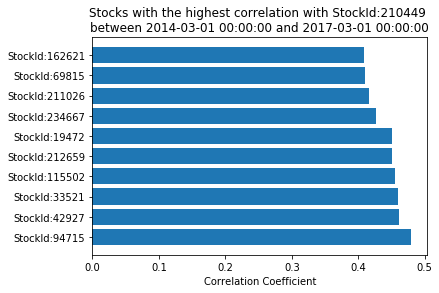

In [18]:
corr = stock_compare.get_stock_correlations('StockId:210449', '2015-09-14', plot=True) # the last 3 years
corr = stock_compare.get_stock_correlations('StockId:210449', '2014-03-01', '2017-03-01', plot = True) # the middle 3 years

The group of stocks with correlations calculated between 2014-03-01 and 2017-03-01 are more homogeneous than those calculated for the 3 years after 2015-09-14. This is evident from looking at the figures above, where the range of the first is 0.13 and the range in the second is 0.7.